In [1]:
import numpy as np
import os
import sys
import copy

import torch
torch.set_num_threads(os.cpu_count())
from torch import nn

import importlib
import json

import matplotlib as mpl
import matplotlib.pyplot as plt

from pipnet import data
from pipnet import model
from pipnet import utils

#import nmrglue as ng
import scipy
import scipy.io

device = "cuda" if torch.cuda.is_available() else "cpu"

np.random.seed(123)

In [11]:
model_name = "PIPNet_model"
model_dir = f"../../trained_models/{model_name}/"
fig_dir = f"../../figures/1D/{model_name}/"

sel_wrs = [
    40000., 42000., 44000., 46000., 48000.,
    50000., 52000., 54000., 56000., 58000., 
    60000., 62000., 64000., 66000., 68000.,
    70000., 72000., 74000., 76000., 78000.,
    80000., 82000., 84000., 86000., 88000.,
    90000., 92000., 94000., 96000., 98000., 100000.
]

dw_max = 1000.

ppm_range = [-5., 20.]

exp_dir = "../../data/experimental_spectra/1D/"

compounds = {
    "Tyrosine_2DJresmk_column_H3prime_vmas": dict(
        use_acqu2s=True,
    ),
    "Tyrosine_0.7mm_T2p": dict(
        use_acqu2s=True,
        use_proc2s=False,
        expno_final=12,
    )
    
}

In [33]:
compounds = {
    "20231003_camphor_07mm_2DJresph_vmas_test": dict(
        use_acqu2s=True,
        use_proc2s=False,
        procno=165413,
    )
    
}

In [34]:
if not os.path.exists(model_dir):
    raise ValueError(f"Unknown model: {model_name}")
    
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)
    
fdir = fig_dir + "predict_experimental/"
if not os.path.exists(fdir):
    os.mkdir(fdir)

In [35]:
with open(f"{model_dir}model_pars.json", "r") as F:
    model_pars = json.load(F)
model_pars["noise"] = 0.

with open(f"{model_dir}data_pars.json", "r") as F:
    data_pars = json.load(F)

In [36]:
net = model.ConvLSTMEnsemble(**model_pars).to(device)
net.load_state_dict(torch.load(model_dir + f"network", map_location=torch.device(device)))
net = net.eval()

In [37]:
for compound in compounds:
    break

In [38]:
ppm, hz, ws, xr, xi, titles, msg = utils.extract_1d_dataset(
    f"{exp_dir}{compound}/",
    procno=compounds[compound]["procno"],
    use_acqu2s=True,
    load_imag=False,
)

In [39]:
ppm

array([ 0.308702  ,  0.30840064,  0.30809928, ..., -0.30758325,
       -0.30788461, -0.30818597])

(50.0, -50.0)

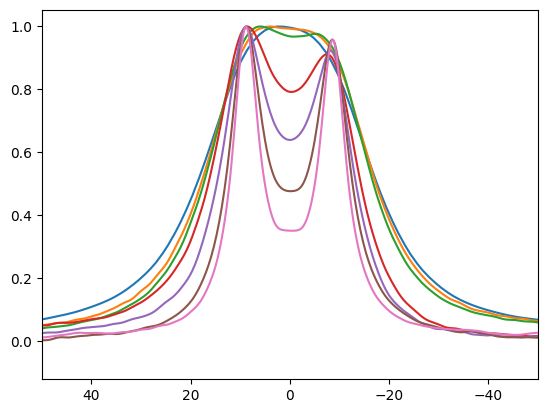

In [40]:
for y in xr:
    plt.plot(hz, y / np.max(y))
plt.xlim(50, -50.)

In [6]:
for compound in compounds:
    
    print(f"Predicting {compound}...")

    load_params = {
        "expno_init": 1,
        "expno_final": 1000,
        "expnos": None,
        "load_imag": data_pars["encode_imag"],
        "procno": 1,
        "use_acqu2s": False,
        "use_proc2s": False
    }

    for k in compounds[compound]:
        if k in load_params:
            load_params[k] = compounds[compound][k]
    
    ppm, hz, ws, xr, xi, titles, msg = utils.extract_1d_dataset(
        f"{exp_dir}{compound}/",
        expno_init=load_params["expno_init"],
        expno_final=load_params["expno_final"],
        expnos=load_params["expnos"],
        load_imag=load_params["load_imag"],
        procno=load_params["procno"],
        use_acqu2s=load_params["use_acqu2s"],
        use_proc2s=load_params["use_proc2s"]
    )

    if msg:
        print(msg)

    ppm, X, msg = utils.prepare_1d_input(
        xr,
        ppm,
        ppm_range,
        ws,
        data_pars,
        xi=xi,
        xmax=0.5
    )

    if msg:
        print(msg)

    wr_inds = [np.argmin(np.abs(ws - w)) for w in sel_wrs if np.min(np.abs(ws - w)) < dw_max ]
    X = X[:, wr_inds]

    with torch.no_grad():
        y_pred, y_std, _ = net(X)
    y_pred = y_pred.numpy()
    y_std = y_std.numpy()

    utils.plot_1d_iso_prediction(
        X[0],
        y_pred[0],
        y_std[0],
        X_offset=0.2,
        pred_offset=0.1,
        xvals=ppm,
        wr_factor=data_pars["wr_norm_factor"],
        xinv=True,
        ylim=[-0.1, 0.8],
        all_steps=True,
        show=False,
        save=f"{fdir}sel_wr_{compound}.pdf"
    )
    
    utils.plot_multiple_1d_iso_predictions(
        X[0],
        y_pred[0],
        y_std[0],
        pred_offset=0.1,
        xvals=ppm,
        xinv=True,
        show=False,
        save=f"{fdir}sel_wr_{compound}_all_preds.pdf"
    )
    
    utils.plot_1d_dataset(
        X[0],
        offset=-0.05,
        xvals=ppm,
        xinv=True,
        show=False,
        save=f"{fdir}dataset_{compound}.pdf"
    )
    
    output = {}
    output["ppm"] = ppm
    output["X"] = X[0, :, 0].numpy()
    output["wr"] = ws[wr_inds]
    output["pred"] = y_pred[0, -1]
    output["pred_std"] = y_std[0, -1]
    
    scipy.io.savemat(f"{fdir}{compound}_preds.mat", output)

Predicting Tyrosine_2DJresmk_column_H3prime_vmas...
Predicting Tyrosine_0.7mm_T2p...

